In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import time
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_json('DiSmldata.json')

In [3]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [4]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [5]:
#setting min_df and max_df

In [6]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.clean_text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.label
    return X, y
X, y = make_xy(df)

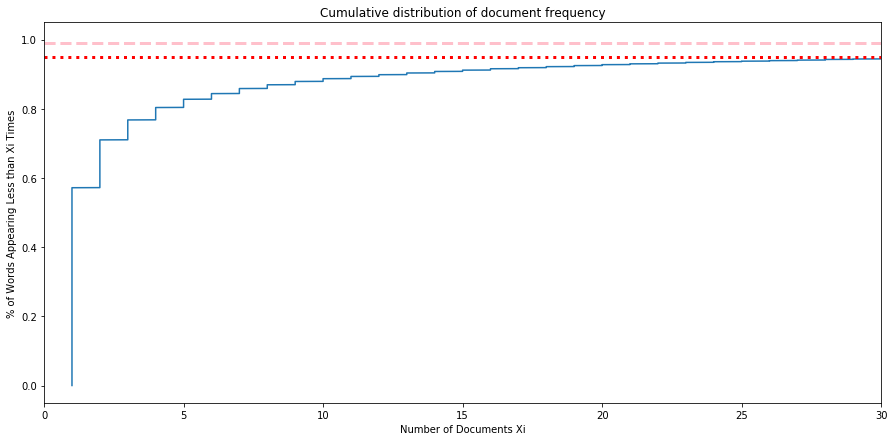

In [7]:
data = np.sum(X>0,axis=0)
sorted_df = np.sort(data).reshape(-1,1)
yvals=np.arange(len(sorted_df))/float(len(sorted_df)-1)
plt.figure(figsize = (15,7))
plt.plot(sorted_df,yvals)
plt.xlim([0,30])
plt.axhline(0.95, c = 'red', linestyle = ':', linewidth = 3)
plt.axhline(0.99, c = 'pink', linestyle = '--', linewidth =3)
plt.xlabel('Number of Documents Xi')
plt.ylabel('% of Words Appearing Less than Xi Times')
plt.title('Cumulative distribution of document frequency')
plt.show()

In [8]:
#Set to 25 max_df 3 min_df

In [39]:
#Count vectorizer Document term matrix

count_vecto = CountVectorizer(stop_words = my_stop_words, min_df = 3, max_df = 25)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [40]:
X_train_vect.shape

(70008, 10910)

In [41]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [42]:
#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 3465.293 / Predict time: 13.373 ---- Precision: 0.543 / Recall: 0.522 / Accuracy: 0.571


In [43]:
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.0871809333811917, 'tweet_len'),
 (0.05623941993206797, 'hash_count'),
 (0.053303823272958586, 'cap_count'),
 (0.048149059936181904, 'punc_count'),
 (0.03861553596128164, 'sadness'),
 (0.03837715595148887, 'joy'),
 (0.03413126826152083, 'fear'),
 (0.026932678530501842, 'anticipation'),
 (0.025679237350042423, 'anger'),
 (0.025064362210333344, 'disgust'),
 (0.022920873933408203, 'trust'),
 (0.020075002671702032, 'emoji_count'),
 (0.016549379354878654, 'surprise'),
 (0.0010727540478134004, 5356),
 (0.0010108191700557913, 7209),
 (0.0007296910812821332, 10165),
 (0.000726193562753153, 8041),
 (0.0007039713234668469, 2175),
 (0.0006460028475057936, 911),
 (0.0006338497065820158, 1859)]

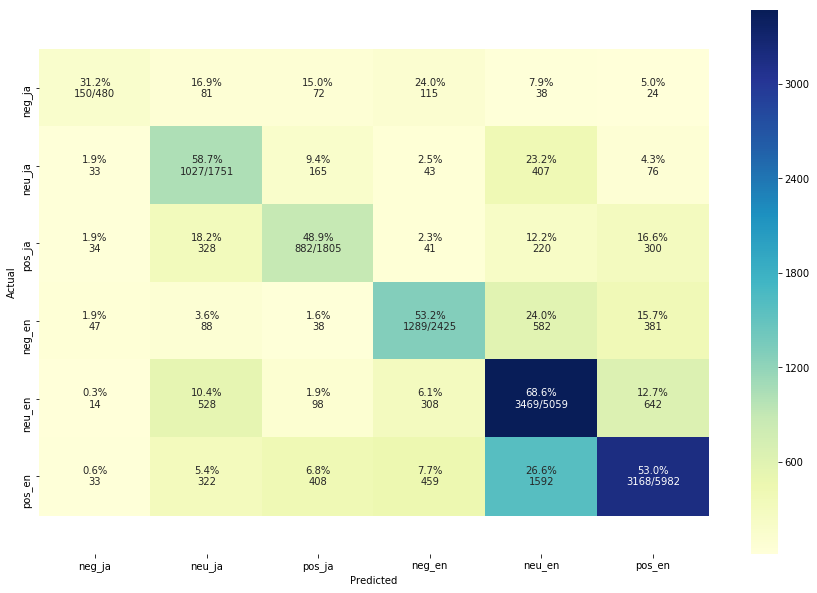

In [44]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

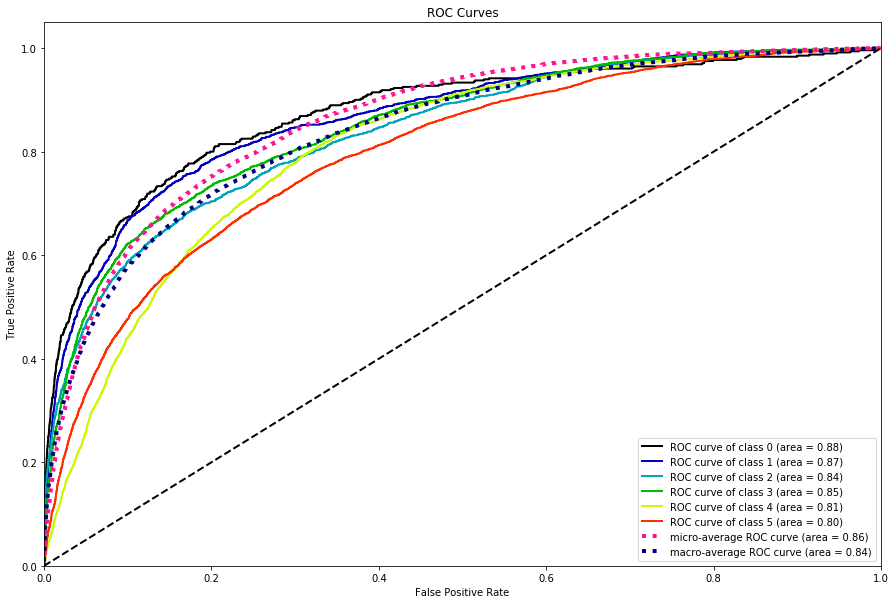

In [45]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.841788 (macro),
0.838590 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.838974 (macro),
0.820714 (weighted by prevalence)


In [17]:
#Max Features 

In [47]:
#Count vectorizer Document term matrix

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10900)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [48]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [49]:
#Random Forest Count vectorizer 


#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 3016.233 / Predict time: 33.638 ---- Precision: 0.762 / Recall: 0.669 / Accuracy: 0.761


In [50]:
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.03504098970620477, 'tweet_len'),
 (0.02547208651300475, 'cap_count'),
 (0.024374023097381608, 'punc_count'),
 (0.02402533836376568, 'hash_count'),
 (0.017280549928427473, 'sadness'),
 (0.016004715412922737, 'joy'),
 (0.014426006522148841, 'fear'),
 (0.012412194443427477, 'anticipation'),
 (0.011850886095804375, 'anger'),
 (0.011033529404551752, 'emoji_count'),
 (0.010860679469648206, 'disgust'),
 (0.010427584181147361, 'trust'),
 (0.007530649164146739, 'surprise'),
 (0.006394665817361104, 2099),
 (0.006048207405533152, 5437),
 (0.0038381074048776274, 5592),
 (0.0037830576130728952, 9538),
 (0.0035329534503110317, 3987),
 (0.003270584461733099, 10197),
 (0.0031132242338492095, 6030)]

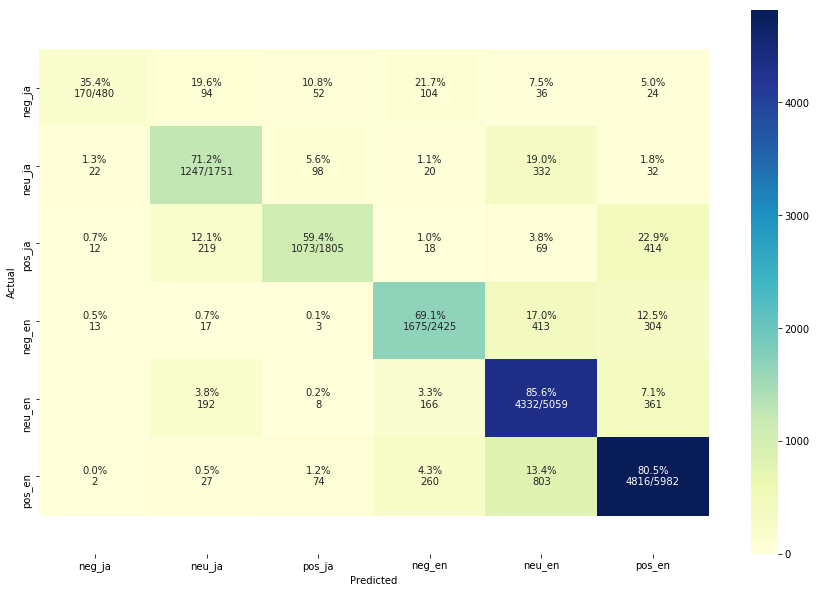

In [51]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

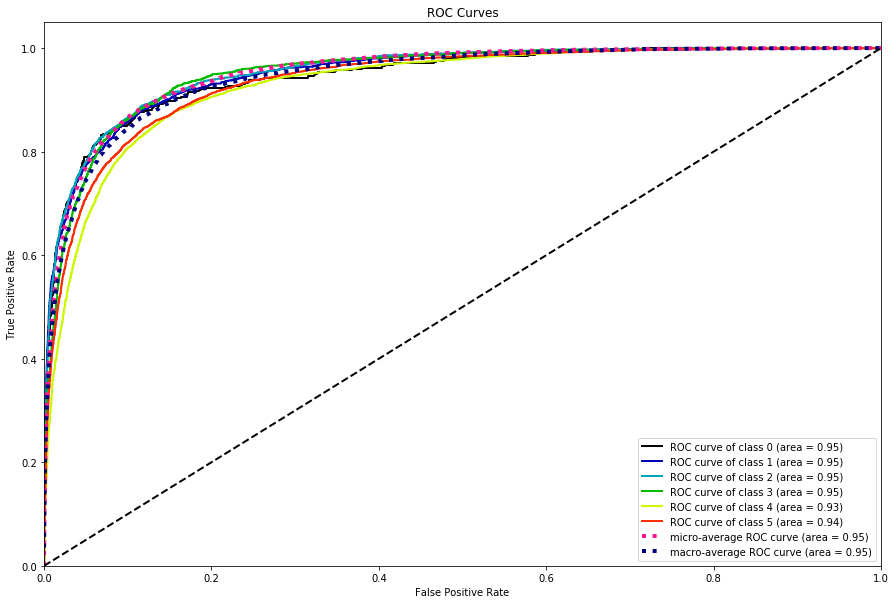

In [52]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [53]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.939914 (macro),
0.944334 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.945645 (macro),
0.941148 (weighted by prevalence)


In [ ]:
#Testing different max features 

In [27]:
#Count vectorizer Document term matrix 5000 features

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 5000)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [28]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [29]:
#Random Forest Count vectorizer 


#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2392.136 / Predict time: 24.503 ---- Precision: 0.757 / Recall: 0.673 / Accuracy: 0.763


In [30]:
#Count vectorizer Document term matrix 10000 features

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10000)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [31]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [32]:
#Random Forest Count vectorizer 


#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2717.102 / Predict time: 37.178 ---- Precision: 0.765 / Recall: 0.671 / Accuracy: 0.761


In [33]:
#Count vectorizer Document term matrix 20000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 20000)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [34]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [35]:
#Random Forest Count vectorizer 


#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 6112.614 / Predict time: 42.352 ---- Precision: 0.762 / Recall: 0.666 / Accuracy: 0.754


In [54]:
def rand_for_feat(features):
    cv = CountVectorizer(stop_words = my_stop_words, max_features = features)
    cv_fit = cv.fit(X_train['clean_text'])
    cv_train = cv_fit.transform(X_train['clean_text'])
    cv_test = cv_fit.transform(X_test['clean_text'])
    X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(cv_train.toarray())], axis=1)
    X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(cv_test.toarray())], axis=1)
   
    #Balance
    ros = ros = RandomOverSampler(random_state=77)
    X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
    
    #Instantiate our model 
    rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                                n_jobs=-1)

    #Model Fit 
    start = time.time()
    rf.fit(X_resampled_ros, y_resampled_ros)
    end = time.time()
    fit_time = (end - start)

    #Model Predict 
    start = time.time()
    y_pred = rf.predict(X_test_vect)
    end = time.time()
    pred_time = (end - start)

    #Model Scoring 
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))



In [55]:
#Count vectorizer Document term matrix 15000
rand_for_feat(15000)


Fit time: 4730.791 / Predict time: 43.938 ---- Precision: 0.762 / Recall: 0.667 / Accuracy: 0.757


In [56]:
#Count vectorizer Document term matrix 3000
rand_for_feat(3000)


Fit time: 1382.992 / Predict time: 19.305 ---- Precision: 0.749 / Recall: 0.67 / Accuracy: 0.759


In [ ]:
# Fit time: 1382.992 / Predict time: 19.305 ---- Precision: 0.749 / Recall: 0.67 / Accuracy: 0.759
# Fit time: 2392.136 / Predict time: 24.503 ---- Precision: 0.757 / Recall: 0.673 / Accuracy: 0.763
# Fit time: 2717.102 / Predict time: 37.178 ---- Precision: 0.765 / Recall: 0.671 / Accuracy: 0.761
# Fit time: 3016.233 / Predict time: 33.638 ---- Precision: 0.762 / Recall: 0.669 / Accuracy: 0.761
# Fit time: 4730.791 / Predict time: 43.938 ---- Precision: 0.762 / Recall: 0.667 / Accuracy: 0.757
# Fit time: 6112.614 / Predict time: 42.352 ---- Precision: 0.762 / Recall: 0.666 / Accuracy: 0.754

In [64]:
rf_table = pd.DataFrame()
rf_table['train_time'] = [1382.992, 2392.136, 2717.102,3016.233, 4730.791, 6112.614]
rf_table['features'] = [3000, 5000, 10000, 10900, 15000, 20000]
rf_table['accuracy_score'] = [0.759, 0.763, 0.761, 0.761, 0.757, 0.754]
rf_table['precision'] = [0.749, 0.757, 0.765, 0.762, 0.762, 0.762]
rf_table['recall'] = [0.67, 0.673, 0.671, 0.669, 0.667, 0.666]

In [65]:
rf_table

,train_time,features,accuracy_score,precision,recall
0,1382.992,3000,0.759,0.749,0.670
1,2392.136,5000,0.763,0.757,0.673
2,2717.102,10000,0.761,0.765,0.671
3,3016.233,10900,0.761,0.762,0.669
4,4730.791,15000,0.757,0.762,0.667
5,6112.614,20000,0.754,0.762,0.666


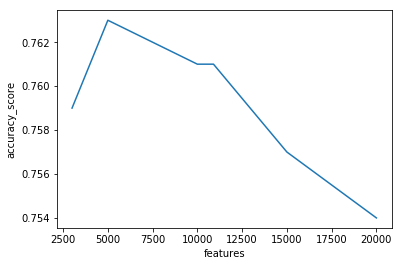

In [67]:
sns.lineplot(rf_table['features'], rf_table['accuracy_score'])
plt.show()

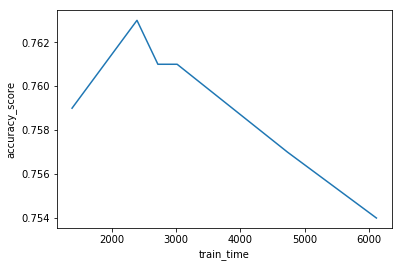

In [68]:
sns.lineplot(rf_table['train_time'], rf_table['accuracy_score'])
plt.show()

In [ ]:
#Choosing the best model 

In [69]:
count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 5000)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [70]:
#Random Forest Count vectorizer 


#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 650, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2283.189 / Predict time: 24.002 ---- Precision: 0.757 / Recall: 0.672 / Accuracy: 0.763


In [71]:
from sklearn.metrics import classification_report
target_names = ['ja_neg', 'ja_neu', 'ja_pos', 'en_neg', 'en_neu', 'en_pos']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

      ja_neg       0.74      0.36      0.48       480
      ja_neu       0.71      0.72      0.71      1751
      ja_pos       0.81      0.60      0.69      1805
      en_neg       0.73      0.70      0.72      2425
      en_neu       0.73      0.86      0.79      5059
      en_pos       0.81      0.80      0.81      5982

    accuracy                           0.76     17502
   macro avg       0.76      0.67      0.70     17502
weighted avg       0.77      0.76      0.76     17502



In [72]:
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.04241565929507099, 'tweet_len'),
 (0.02970533540811362, 'cap_count'),
 (0.028470743677011703, 'punc_count'),
 (0.02700800521876545, 'hash_count'),
 (0.01740932210930088, 'sadness'),
 (0.015956702984879504, 'joy'),
 (0.01452532088171195, 'fear'),
 (0.012384073502194075, 'anticipation'),
 (0.012216068665242793, 'emoji_count'),
 (0.01200129756588913, 'anger'),
 (0.01094615615964915, 'disgust'),
 (0.01037255753254415, 'trust'),
 (0.007635511980753084, 968),
 (0.007373639068967705, 'surprise'),
 (0.006818668540586973, 2509),
 (0.004159781427302617, 2803),
 (0.004082128452101227, 2598),
 (0.003738626152623292, 4412),
 (0.0037357890729629163, 4714),
 (0.0036018430947618385, 1747)]

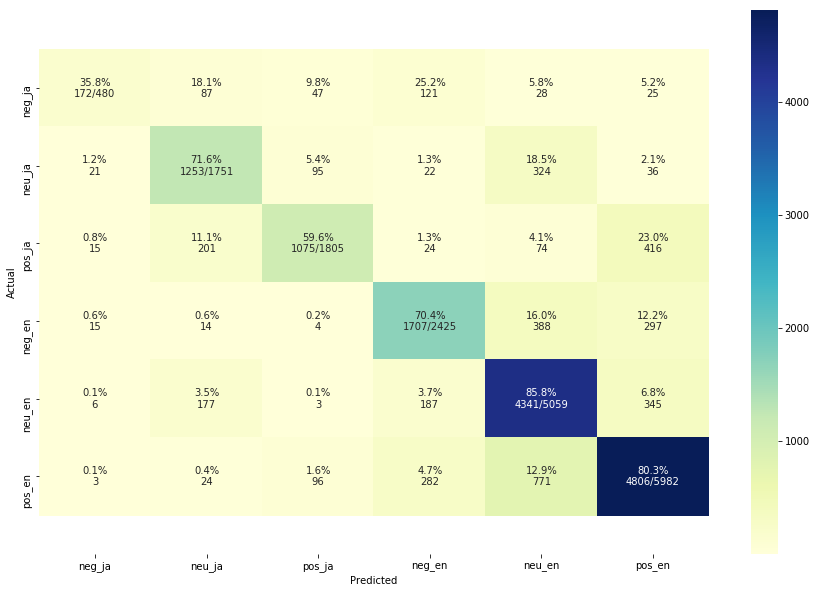

In [73]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

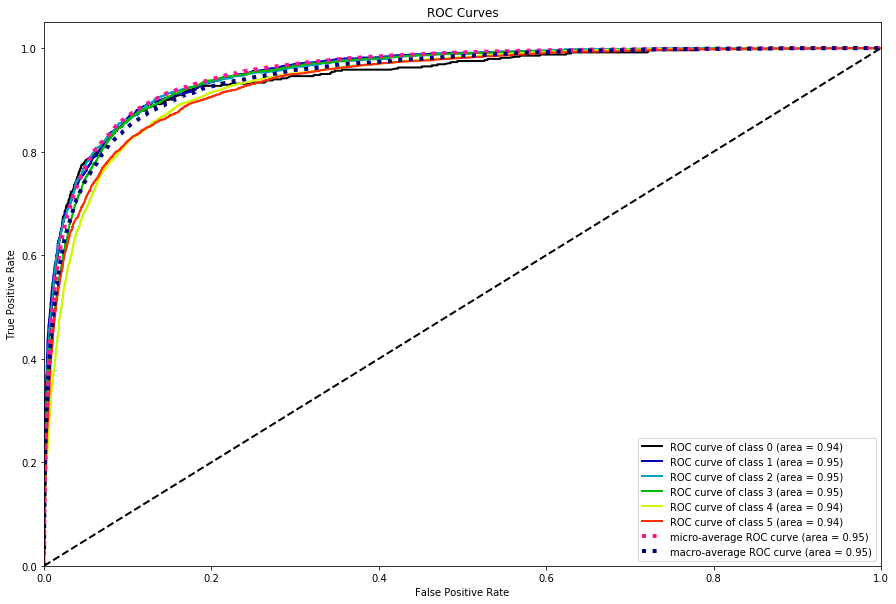

In [74]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [75]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.939380 (macro),
0.944107 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.945569 (macro),
0.941939 (weighted by prevalence)
